<a href="https://colab.research.google.com/github/wiesehahn/waldmaske/blob/master/notebooks/query_osm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table class="ee-notebook-buttons" align="left">
    <td><a target="_blank"  href="https://github.com/wiesehahn/waldmaske/blob/master/notebooks/query_osm.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a></td>
    <td><a target="_blank"  href="https://colab.research.google.com/github/wiesehahn/waldmaske/blob/master/notebooks/query_osm.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a></td>
</table>

# OSM Data
Loading Data from OpenStreetMap with Python and the Overpass API and bringing it to Earth Engine for processing

## Get Data

In [ ]:
import requests
import json

overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];

area["ISO3166-2"="DE-NI"]->.suchgebiet;

(
  way
  ["highway"]
  [highway!~"footway|path|bridleway|steps"]
  [tracktype!~"grade4|grade5"]
  (area.suchgebiet);
);
out skel geom qt;
"""
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
data = response.json()

convert to GeoJSON FeatureCollection

In [ ]:
import subprocess

In [ ]:
try:
    import geojson
except ImportError:
    print('geojson package not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geojson'])
    import geojson

# adapted from https://github.com/yannforget/OSMxtract/blob/master/osmxtract/overpass.py
def as_linestrings(elements):
    """Parse an iterable of elements to retrieve a FeatureCollection of linestrings.
    Parameters
    ----------
    elements : list of dict
        JSON response elements.
    Returns
    -------
    feature_collection : dict
        Output GeoJSON FeatureCollection.
    """
    features = []
    elements = [e for e in elements if e.get('type') == 'way']
    for elem in elements:
        coords = [[node['lon'], node['lat']] for node in elem['geometry']]
        geom = geojson.LineString(coordinates=coords)
        features.append(geojson.Feature(elem['id'], geom))
    return geojson.FeatureCollection(features)
    
feature_collection = as_linestrings(data['elements'])

## Data to EE

write file to Colab environment

In [ ]:
from geojson import dump

with open('osm-ways_ni.geojson', 'w') as f:
   dump(feature_collection, f)

In [ ]:
args = ['ogr2ogr', '-f', 'ESRI Shapefile', 'osm-ways_ni.shp', 'osm-ways_ni.geojson']
test = subprocess.Popen(args)

save files on local disk

In [ ]:
from google.colab import files

In [ ]:
#files.download('osm-ways_ni.geojson')

In [ ]:
files.download('osm-ways_ni.prj')
files.download('osm-ways_ni.dbf')
files.download('osm-ways_ni.shp')
files.download('osm-ways_ni.shx')


(zip files and upload manually to EE)

## Plot Data

convert to geodataframe

In [ ]:
try:
    import geopandas as gpd
except ImportError:
    print('geopandas package not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geopandas'])
    import geopandas as gpd

In [ ]:
# To GeoPandas GeoDataFrame:
geodataframe = gpd.GeoDataFrame.from_features(feature_collection)

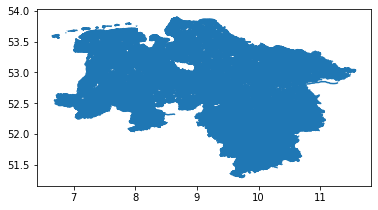

In [ ]:
geodataframe.plot()

# Raster data
load raster data file generated in Google Earth Engine

In [ ]:
# Installs geemap package
try:
    import geemap
except ImportError:
    print('geemap package not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])
    import geemap

# Checks whether this notebook is running on Google Colab
try:
        import google.colab
        import geemap.eefolium as emap
except:
        import geemap as emap
        
# Authenticates and initializes Earth Engine
import ee

try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()